# Propagação em Redes Neurais (na mão!)

Vimos os alicerces básicos de redes neurais e *Deep Learning*, e também um conceito-chave, a *score function*. Nesta aula, irei falar sobre o outro conceito-chave: *Cost function*.

Recapitulando o que foi visto até agora, vimos que o preditor $\hat{y}$ é obtido (neste caso) a partir da ativação de $z=w^T x + b$ pela função sigmóide. Tudo isso fica assim:

$$
\hat{y} = \sigma(z) = \sigma(w^T x + b) = \frac{1}{1 + e^{-z}}
$$

> *Note que eu substitui o símbolo $\theta$, usado na última aula, por $w$. Estou menos preocupado com o rigor matemático e exatidão da forma que com o aprendizado efetivo.*


Também entendemos que, dado um conjunto de amostras de treinamento $\{ (x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \dots, (x^{(m)}, y^{(m)}) \}$, queremos obter $\hat{y}^{(i)} \approx y^{(i)}$.

Seguindo a notação matemática de usar o índice $i$ sobrescrito para representa a *i-nésima* amostra, pode-se generalizar;

$$
\hat{y}^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}}
$$

#### 2. *Cost Function*

Já sabemos usar uma função que passa nossa imagem por diversos parâmetros e que consegue classificá-la como sendo uma aeronave ou não.

**Mas como saber se nosso algoritmo está indo bem?**

A primeira coisa que temos que mensurar é o quão distante estamos da solução correta.

Se você já trabalhou com problemas de regressão em *Machine Learning*, sabe que métricas como MSE, RMSE, entre outras, são bem populares.

No entanto, este é um problema de regressão logística. Se você está mais familiarizado com Cálculo, sabe que cairíamos em um espaço de soluções não-convexo. Na prática, teríamos vários ótimos locais, fazendo com que o *Gradient Descent* não funcione bem.

Para trabalhar um problema de otimização convexo, utilizamos a seguinte *Loss Function*:

$\mathcal{L}(\hat{y}, y) = - (y \log \hat{y} + (1 - y)log(1 - \hat{y}))$

*Loss function* é quando aplicamos $\mathcal{L}$ a uma amostra.

***Cost Function***  é quando consideramos todo o *dataset*, e queremos obter o custo do erro das previsões:

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m}\mathcal{L}(\hat{y}^{(i)}, y^{(i)}) \\
J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)})]
$$

Agora somos capazes de avaliar quão boa está sendo uma previsão do nosso algoritmo.



## Propagação nas Redes Neurais

Os maiores problemas de implementação de Redes Neurais na mão são os conflitos de dimensionalidade. Agora quero que você preste muita atenção em uma coisa.

**Não tem para onde correr.**

Se você quer evoluir em *Deep Learning*, tem que passar a gostar de matemática. Caso contrário, sera um eterno usuário de coisas prontas, sem a mínima ideia do que está fazendo.

Para entender como as dimensões das matrizes interferem em operações de multiplicação, você tem que relembrar as propriedades básicas que foram passadas no ensino médio. Relembradas as propriedades básicas, recomendo fortemente investir em Álgebra Linear.

Vou dar um exemplo bem simples de como o pensamento algébrico facilita muito o seu trabalho (além de ser mais eficiente).

---

**INÍCIO DO EXEMPLO DE ÁLGEBRA LINEAR**

---

In [1]:
# importa bibliotecas
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Exemplo de vetorização
# Quantidades de itens comprados pro 3 clientes
compras = np.array([[1, 2, 3],
                    [0, 3, 1],
                    [0, 0, 2]])

preco = np.array([10, 20, 100]).reshape(1, -1)

In [3]:
# Resolvendo usando for loops
for i, _ in enumerate(compras):
    total = 0
    print("Cliente {}".format(i))

    for j, _ in enumerate(compras):
        total += compras[i][j] * preco[0][j]
        print(compras[i][j], "*", preco[0][j], "=", compras[i][j] * preco[0][j])

    print("Total: {}".format(total), "\n")

Cliente 0
1 * 10 = 10
2 * 20 = 40
3 * 100 = 300
Total: 350 

Cliente 1
0 * 10 = 0
3 * 20 = 60
1 * 100 = 100
Total: 160 

Cliente 2
0 * 10 = 0
0 * 20 = 0
2 * 100 = 200
Total: 200 



In [4]:
# Resolvendo com Algebra Linear
# ver as compras por itens e clientes
compras * preco

array([[ 10,  40, 300],
       [  0,  60, 100],
       [  0,   0, 200]])

In [5]:
# ver quanto cada cliente gastou
np.dot(preco, compras.T)

array([[350, 160, 200]])

---

**FIM DO EXEMPLO DE ÁLGEBRA LINEAR**

---

## *Forward Propagation*

Antes de falarmos em aprendizado, quero dividir o fluxo que acontece dentro das redes em duas etapas distintas:

1. *Forward Propagation*
2. *Backward Propagation*

Nesta Aula 006 nós iremos tratar da propagação, a *forward propagation*. Numa explicação prática, entenda como o caminho de ida.

**Etapas da *forward propagation***
1. Padronizar as dimensões de `X` e `y`
2. Inicializar os parâmetros `w` e `b`
3. Calcular $z = w^T x + b$
4. Calcular $\sigma(-z) = \frac{1}{1 + e^{(-z)}}$
5. Calcular $J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)})]$

Para simplificar ao máximo a implementação, usarei um *dataset* de imagens de gatos bem simplificado, disponibilizado por Andrew Ng em sua especialização.

In [6]:
# download do dataset cat vs non-cat
!wget -q https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/catvsnoncat/train_catvnoncat.h5
!wget -q https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/catvsnoncat/test_catvnoncat.h5

# Importar os dados do arquivo .h5
train_dataset = h5py.File('train_catvnoncat.h5', 'r')
test_dataset = h5py.File('test_catvnoncat.h5', 'r')

# dados de treino
train_x = np.array(train_dataset['train_set_x'][:])
train_y = np.array(train_dataset['train_set_y'][:])

# dados de teste
test_x = np.array(test_dataset['test_set_x'][:])
test_y = np.array(test_dataset['test_set_y'][:])

Para ver como o *dataset* está composto, vamos dar uma olhadinha em duas amostras, uma de cada classe:

* Cat
* Non-Cat

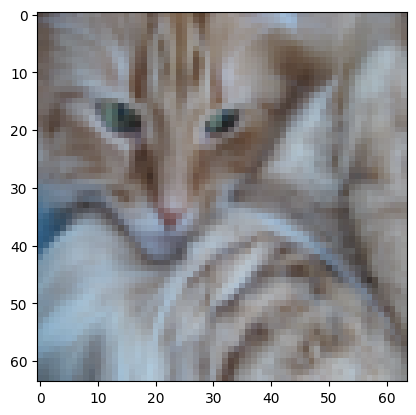

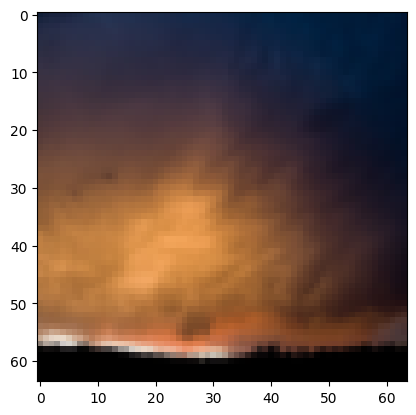

In [7]:
# ver o exemplo de uma imagem cat vs non-cat
idx_cat = np.where(train_y == 1)[0][0]
idx_noncat = np.where(train_y == 0)[0][0]

plt.imshow(train_x[idx_cat])
plt.show()
plt.imshow(train_x[idx_noncat])
plt.show()

Como já falamos, um problema comum é as pessoas não se atentarem à dimensionalidade das variáveis. Vamos dar uma olhada nas definições da próxima aula e notar como o *output* da próxima célula acima não está adequado para `y` (tanto para o treino quanto para o teste).

<p align="center">
<img height="250" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/resumo-aula006.png">
</p>

In [8]:
# ver a dimensionalidade dos nossos dados de treino e teste
for _, j in enumerate([train_x, train_y, test_x, test_y]):
    print(j.shape)

(209, 64, 64, 3)
(209,)
(50, 64, 64, 3)
(50,)


In [9]:
# shape original
train_y.shape

(209,)

In [10]:
# novo shape
train_y.reshape(1, train_y.shape[0]).shape

(1, 209)

In [11]:
# reshape nas variáveis
train_y = train_y.reshape(1, train_y.shape[0])
test_y = test_y.reshape(1, test_y.shape[0])

Identificando as demais dimensionalidades

In [12]:
m_train = train_x.shape[0]
m_test = test_x.shape[0]
num_pixels = train_x.shape[1]
img_shape = (train_x.shape[1], train_x.shape[2], train_x.shape[3])

print("Amostras de treinamento: m_train: {}".format(m_train))
print("Amostras de teste: m_test: {}".format(m_test))
print("Dimensionalidade das imagens: {}".format(img_shape))

Amostras de treinamento: m_train: 209
Amostras de teste: m_test: 50
Dimensionalidade das imagens: (64, 64, 3)


Para alimentar corretamente o modelo, devemos achatar cada imagem individual. De `(64, 64, 3)`, devemos dar um `reshape` para `(64 *  64 * 3, 1) = (12288, 1)`.

Não esqueça que não temos apenas uma imagem, mas várias dela. O nosso `reshape` deve levar em consideração que cada coluna representará uma imagem "achatada".

> *Para reshape do tipo `(m, h, w, c)` em `(h * w * c, m)`, use o `reshape` da seguinte maneira.*

In [13]:
# shape original
train_x.shape

(209, 64, 64, 3)

In [14]:
# novo shape
train_x.reshape(m_train, -1).shape

(209, 12288)

In [15]:
# novo shape transposto
train_x.reshape(m_train, -1).T.shape  # transposta

(12288, 209)

In [16]:
# reshape nas variáveis

train_x_flatten = train_x.reshape(m_train, -1).T
test_x_flatten = test_x.reshape(m_test, -1).T

print(train_x_flatten.shape)
print(train_y.shape)
print(test_x_flatten.shape)
print(test_y.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


In [17]:
# padronizar os inputs
train_x_clean = train_x_flatten / 255.
test_y_clean = test_x_flatten / 255.

### Propagação na Prática

In [18]:
def propagate(X, Y):

    m = X.shape[1]

    w = np.zeros((X.shape[0], 1))
    b = 0

    z = np.dot(w.T, X) + b
    A = 1 / (1 + np.exp(-z))
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))

    return cost


In [19]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
cost = propagate(X, Y)
print ("cost =", cost)

cost = 0.6931471805599453
